<h2>개인 구글 드라이브와 colab 연동</h2>

In [1]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
!pip install pytorch-crf

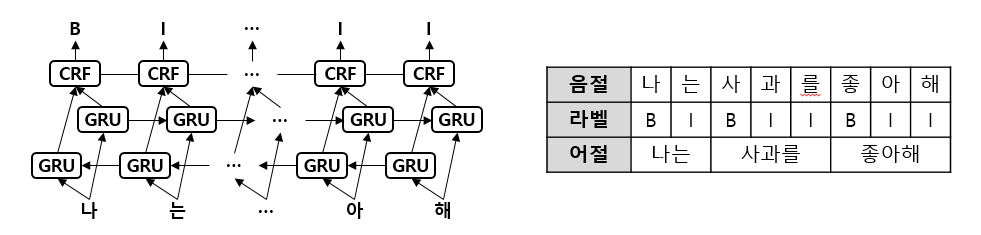

In [ ]:
from IPython.display import Image
Image("/gdrive/My Drive/colab/rnn_crf/bi_gru_crf.PNG")

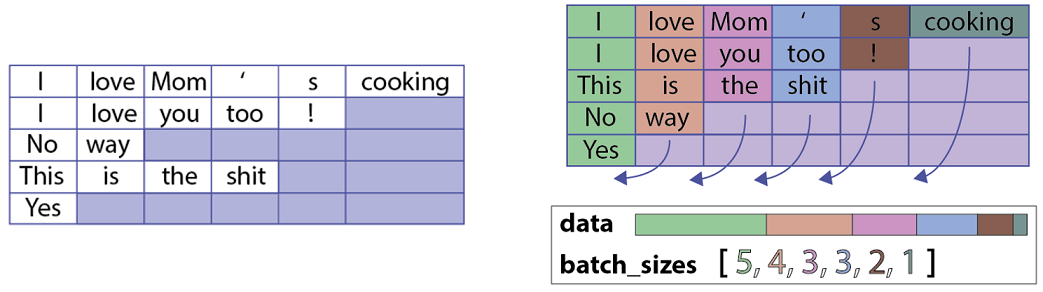

In [ ]:
from IPython.display import Image
Image("/gdrive/My Drive/colab/rnn_crf/pack_padded_sequence.png")

<h2>RNN_CRF 모델</h2>

In [3]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchcrf import CRF


class RNN_CRF(nn.Module):

    def __init__(self, config):
        super(RNN_CRF, self).__init__()

        # 전체 음절 개수
        self.eumjeol_vocab_size = config["eumjeol_vocab_size"]

        # 음절 임베딩 사이즈
        self.embedding_size = config["embedding_size"]

        # GRU 히든 사이즈
        self.hidden_size = config["hidden_size"]

        # 분류할 태그의 개수
        self.number_of_tags = config["number_of_tags"]

        # 입력 데이터에 있는 각 음절 index를 대응하는 임베딩 벡터로 치환해주기 위한 임베딩 객체
        # 기존에 사전학습 된 음절 임베딩을 사용할 수도 있고 랜덤으로 초기화 한 후,
        # 모델 학습 과정 중에 같이 학습 시키는 것도 가능
        # 예제 코드는 랜덤으로 초기화 한 후 같이 학습하도록 설정
        self.embedding = nn.Embedding(num_embeddings=self.eumjeol_vocab_size,
                                      embedding_dim=self.embedding_size,
                                      padding_idx=0)

        self.dropout = nn.Dropout(config["dropout"])

        # Bi-GRU layer
        self.bi_gru = nn.GRU(input_size = self.embedding_size,
                             hidden_size= self.hidden_size,
                             num_layers=1,
                             batch_first=True,
                             bidirectional=True)

        # CRF layer
        self.crf = CRF(num_tags=self.number_of_tags, batch_first=True)

        # fully_connected layer를 통하여 출력 크기를 number_of_tags에 맞춰줌
        # (batch_size, max_length, hidden_size*2) -> (batch_size, max_length, number_of_tags)
        self.hidden2num_tag = nn.Linear(in_features=self.hidden_size*2, out_features=self.number_of_tags)

    def forward(self, inputs, input_lengths, labels=None):
        # (batch_size, max_length) -> (batch_size, max_length, embedding_size)
        eumjeol_inputs = self.embedding(inputs)

        # >>> seq = torch.tensor([[1,2,0], [3,0,0], [4,5,6]]), lens = [2, 1, 3]
        # >>> packed = pack_padded_sequence(seq, lens, batch_first=True, enforce_sorted=False)
        # >>> packed
        # PackedSequence(data=tensor([4, 1, 3, 5, 2, 6]), batch_sizes=tensor([3, 2, 1]),
        #                sorted_indices=tensor([2, 0, 1]), unsorted_indices=tensor([1, 2, 0]))
        # >>> seq_unpacked, lens_unpacked = pad_packed_sequence(packed, batch_first=True)
        # >>> seq_unpacked
        # tensor([[1, 2, 0],
        #         [3, 0, 0],
        #         [4, 5, 6]])
        # >>> lens_unpacked
        # tensor([2, 1, 3])

        packed_eumjeol_inputs = pack_padded_sequence(eumjeol_inputs, input_lengths, batch_first=True, enforce_sorted=False)
        packed_hidden_outputs, hidden_states = self.bi_gru(packed_eumjeol_inputs)
        hidden_outputs_unpacked, output_lengths_unpacked = pad_packed_sequence(packed_hidden_outputs, batch_first=True)

        # (batch_size, curr_max_length, hidden_size*2)
        hidden_outputs_unpacked = self.dropout(hidden_outputs_unpacked)

        # (batch_size, curr_max_length, hidden_size*2) -> (batch_size, curr_max_length, number_of_tags)
        hidden_outputs_unpacked = self.hidden2num_tag(hidden_outputs_unpacked)

        if(labels is not None):
            curr_max_length = hidden_outputs_unpacked.size()[1]
            # (batch_size, max_length) -> (batch_size, curr_max_length)
            labels = labels[:, :curr_max_length]

            log_likelihood = self.crf(emissions=hidden_outputs_unpacked,
                                      tags=labels,
                                      reduction="mean")

            loss = log_likelihood * -1.0

            return loss
        else:
            output = self.crf.decode(emissions=hidden_outputs_unpacked)

            return output

<h2>데이터 읽고 전처리 하기</h2>

<pre>
<b>1. read_file(file_path)</b>
  "train.txt", "test.txt" 파일을 읽기 위한 함수
  
  데이터 예시)
    나 의 사 랑 한 글 날 \t B I B I B I I
  
  read_file(file_path)
  args
    file_path : 읽고자 하는 데이터의 경로
  return
    음절 sequence, 각 음절에 대응하는 라벨 sequence를 담고 있는 리스트
    
    출력 예시)
      datas = [
        (["나", "의", "사", "랑", "한", "글", "날"], ["B", "I", "B", "I", "B", "I", "I"])

        (...),
        
        ]
      
<b>2. read_vocab_data(eumjeol_vocab_file_path, label_vocab_file_path)</b>
  "eumjeol_vocab.txt", "label_vocab.txt" 파일을 읽고 음절과 라벨을 indexing하기 위한 딕셔너리를 생성
   
  read_vocab_data(eumjeol_vocab_file_path, label_vocab_file_path)
  args
    eumjeol_vocab_file_path : 음절 어휘 파일 경로
    label_vocab_file_path : 라벨 어휘 파일 경로
  return
    eumjeol2idx, idx2eumjeol, label2idx, idx2label 딕셔너리
    
    eumjeol2idx : 음절을 대응하는 index로 치환하기 위한 딕셔너리
    idx2eumjeol : index를 대응하는 음절로 치환하기 위한 딕셔너리
    label2idx : 라벨을 대응하는 index로 치환하기 위한 딕셔너리
    idx2label : index를 대응하는 라벨로 치환하기 위한 딕셔너리
    
<b>3. convert_data2feature(datas, max_length, eumjeol2idx, label2idx)</b>
  입력 데이터를 고정된 길이로 변환 후 indexing
  Tensor로 변환
   
  convert_data2feature(datas, max_length, eumjeol2idx, label2idx)
  args
    datas : 음절 sequence, 각 음절에 대응하는 라벨 sequence를 담고 있는 리스트
    max_length : 입력의 최대 길이
    eumjeol2idx : 음절을 대응하는 index로 치환하기 위한 딕셔너리
    label2idx : 라벨을 대응하는 index로 치환하기 위한 딕셔너리
  return
    입력 데이터와 각각의 데이터의 실제 길이를 담고 있는 Tensor
    
  전처리 예시)
    datas = [(["나", "의", "사", "랑", "한", "글", "날"], ["B", "I", "B", "I", "B", "I", "I"]),

    (...),
    
    ]
    
    사전 설정한 문장의 최대 길이를 10이라고 가정
    
    ["나", "의", "사", "랑", "한", "글", "날"] -> ["나", "의", "사", "랑", "한", "글", "날", "<PAD>", "<PAD>", "<PAD>"]
    ["나", "의", "사", "랑", "한", "글", "날", "<PAD>", "<PAD>", "<PAD>"] -> [ 23, 2, 55, 65, 96, 12, 4, 0, 0, 0 ]
    
    [ "B", "I", "B", "I", "B", "I", "I" ] -> [ "B", "I", "B", "I", "B", "I", "I", "<PAD>", "<PAD>", "<PAD>" ]
    [ "B", "I", "B", "I", "B", "I", "I", "<PAD>", "<PAD>", "<PAD>" ] -> [ 1, 2, 1, 2, 1, 2, 2, 0, 0, 0 ]    

    eumjeol_features : Tensor([ 23, 2, 55, 65, 96, 12, 4, 0, 0, 0 ], [...], ...)
    label_features : Tensor([ 1, 2, 1, 2, 1, 2, 2, 0, 0, 0 ], [...], ...)
    eumjeol_feature_lengths : Tensor([7, ..., ])
 </pre>


In [4]:
import torch
import numpy as np
from tqdm import tqdm


# 학습 or 평가 데이터를 읽어 리스트에 저장
def read_data(file_path):
    with open(file_path, "r", encoding="utf8") as inFile:
        lines = inFile.readlines()

    datas = []
    for line in tqdm(lines, desc="read_data"):

        # 입력 문장을 \t으로 분리
        pieces = line.strip().split("\t")

        # 데이터의 형태가 올바른지 체크
        assert len(pieces) == 2

        # 입력 문자열을 음절 단위로 분리
        eumjeol_sequence, label_sequence = pieces[0].split(), pieces[1].split()

        # 음절 sequence의 길이와 라벨 sequence의 길이가 동일한지 체크
        assert len(eumjeol_sequence) == len(label_sequence)

        datas.append((eumjeol_sequence, label_sequence))

    return datas

# 데이터를 읽고 각각의 딕셔너리 생성
def read_vocab_data(eumjeol_vocab_data_path, label_vocab_data_path):
    eumjeol2idx, idx2eumjeol, label2idx, idx2label = {}, {}, {}, {}

    with open(eumjeol_vocab_data_path, "r", encoding="utf8") as inFile:
        lines = inFile.readlines()

    for line in lines:
        eumjeol = line.strip()
        eumjeol2idx[eumjeol] = len(eumjeol2idx)
        idx2eumjeol[eumjeol2idx[eumjeol]] = eumjeol

    with open(label_vocab_data_path, "r", encoding="utf8") as inFile:
        lines = inFile.readlines()

    for line in lines:
        label = line.strip()
        label2idx[label] = len(label2idx)
        idx2label[label2idx[label]] = label

    return eumjeol2idx, idx2eumjeol, label2idx, idx2label


# 입력 데이터 전처리
def convert_data2feature(datas, max_length, eumjeol2idx, label2idx):
    # 음절 데이터, 각 데이터의 실제 길이, 라벨 데이터를 담을 리스트
    eumjeol_features, eumjeol_feature_lengths, label_features = [], [], []

    for eumjeol_sequence, label_sequence in tqdm(datas, desc="convert_data2feature"):
        
        # 사전 설정한 max_length의 길이를 갖는 numpy array 생성
        eumjeol_feature, label_feature = np.zeros(shape=(max_length), dtype=np.int), np.zeros(shape=(max_length), dtype=np.int)

        # 음절 sequence의 실제 길이를 구하여 리스트에 저장
        eumjeol_feature_length = len(eumjeol_sequence[:max_length])

        # 음절 sequence와 라벨 sequence의 각 값들을 index로 치환하고 위에서 생성한 numpy array에 저장
        for index in range(len(eumjeol_sequence[:max_length])):
            eumjeol_feature[index] = eumjeol2idx[eumjeol_sequence[index]]
            label_feature[index] = label2idx[label_sequence[index]]

        # 변환한 데이터를 각 리스트에 저장
        eumjeol_features.append(eumjeol_feature)
        eumjeol_feature_lengths.append(eumjeol_feature_length)
        label_features.append(label_feature)

    # 변환한 데이터를 Tensor 객체에 담아 반환
    eumjeol_features = torch.tensor(eumjeol_features, dtype=torch.long)
    eumjeol_feature_lengths = torch.tensor(eumjeol_feature_lengths, dtype=torch.long)
    label_features = torch.tensor(label_features, dtype=torch.long)

    return eumjeol_features, eumjeol_feature_lengths, label_features

<h2>RNN_CRF모델 학습</h2>

<pre>
<b>1. read_data(file_path) 함수를 사용하여 학습 및 평가 데이터 읽기</b>

<b>2. read_vocab_data(eumjeol_vocab_data_path, label_vocab_data_path) 함수를 사용하여 어휘 딕셔너리 생성</b>

<b>3. convert_data2feature(datas, max_length, eumjeol2idx, label2idx) 함수를 사용하여 데이터 전처리</b>

<b>4. RNN_CRF 모델 객체 선언</b>

<b>5. epoch를 돌때마다 평가 데이터를 이용하여 성능 측정 후 기존 성능보다 높은 경우에만 모델 파일 저장</b>
</pre>

In [5]:
import os
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score

import torch
from torch.utils.data import (DataLoader, TensorDataset)
import torch.optim as optim


def train(config):
    # 학습 데이터 읽기
    train_datas = read_data(config["train_data_path"])

    # 평가 데이터 읽기
    test_datas = read_data(config["test_data_path"])

    # 어휘 딕셔너리 생성
    eumjeol2idx, idx2eumjeol, label2idx, idx2label = read_vocab_data(config["eumjeol_vocab_data_path"], 
                                                                     config["label_vocab_data_path"])

    # 입력 데이터 전처리
    train_eumjeol_features, train_eumjeol_feature_lengths, train_label_features \
    = convert_data2feature(train_datas, config["max_length"], eumjeol2idx, label2idx)
    test_eumjeol_features, test_eumjeol_feature_lengths, test_label_features \
    = convert_data2feature(test_datas, config["max_length"], eumjeol2idx, label2idx)

    # 학습 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
    train_features = TensorDataset(train_eumjeol_features, train_eumjeol_feature_lengths, train_label_features)
    train_dataloader = DataLoader(train_features, shuffle=True, batch_size=config["batch_size"])

    # 평가 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
    test_features = TensorDataset(test_eumjeol_features, test_eumjeol_feature_lengths, test_label_features)
    test_dataloader = DataLoader(test_features, shuffle=False, batch_size=1)

    # RNN_CRF 모델 객체 생성
    model = RNN_CRF(config).cuda()
    
    # 모델 학습을 위한 optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 모델의 정확도를 저장하기 위한 변수
    max_accuracy = 0
    for epoch in range(config["epoch"]):
        model.train()

        losses = []
        for step, batch in enumerate(tqdm(train_dataloader, desc="epoch_{}_train".format(epoch+1))):
            batch = tuple(t.cuda() for t in batch)

            # 음절 데이터, 각 데이터의 실제 길이, 라벨 데이터
            inputs, input_lengths, labels = batch[0], batch[1], batch[2]

            # 모델 학습
            loss = model(inputs, input_lengths, labels)

            # 역전파 단계를 실행하기 전에 변화도를 0으로 변경
            optimizer.zero_grad()

            # loss 값으로부터 모델 내부 각 매개변수에 대하여 gradient 계산
            loss.backward()

            # 모델 내부 각 매개변수 가중치 갱신
            optimizer.step()

            # batch 단위 loss 값 저장
            losses.append(loss.data.item())

        model.eval()

        # 모델의 출력 결과와 실제 정답값을 담을 리스트
        total_predicts, total_labels = [], []
        for step, batch in enumerate(tqdm(test_dataloader, desc="epoch_{}_test".format(epoch+1))):
            batch = tuple(t.cuda() for t in batch)

            # 음절 데이터, 각 데이터의 실제 길이, 라벨 데이터
            inputs, input_lengths, labels = batch[0], batch[1], batch[2]

            # 모델 평가
            predicts = model(inputs, input_lengths)

            inputs, input_lengths, predicts, labels = inputs[0], input_lengths[0], predicts[0], labels[0]
            # Tensor를 numpy array로 변경
            input_lengths = input_lengths.cpu().numpy()

            # 출력 sequence의 길이와 입력 데이터의 실제 길이가 같은지 체크
            assert len(predicts) == input_lengths

            # Tensor를 numpy array로 변경하고 입력 데이터의 실제 길이만큼 추출
            inputs = inputs.cpu().numpy().tolist()[:input_lengths]
            labels = labels.cpu().numpy().tolist()[:input_lengths]

            # batch 단위 출력 결과와 정답을 리스트에 저장
            total_predicts += predicts
            total_labels += labels

        # 정확도 계산
        accuracy = accuracy_score(total_labels, total_predicts)

        # 현재의 정확도가 기존 정확도보다 높은 경우 모델 파일 저장
        if(max_accuracy < accuracy):
            max_accuracy = accuracy

            torch.save(model.state_dict(), os.path.join(output_dir, "epoch_{}.pt".format(epoch+1)))

        # epoch 별로 평균 loss 값과 정확도 출력
        print("Average loss : {},\tAccuracy : {}\n".format(np.mean(losses), accuracy))

<h2>RNN_CRF 모델 평가</h2>

<pre>
<b>1. read_data(file_path) 함수를 사용하여 평가 데이터 읽기</b>

<b>2. read_vocab_data(eumjeol_vocab_data_path, label_vocab_data_path) 함수를 사용하여 어휘 딕셔너리 생성</b>

<b>3. convert_data2feature(datas, max_length, eumjeol2idx, label2idx) 함수를 사용하여 데이터 전처리</b>

<b>4. RNN_CRF 모델 객체 선언</b>

<b>5. load_state_dict() 함수를 사용하여 학습한 모델 파일로부터 가중치를 불러옴</b>

<b>6. make_sentence(inputs, predicts, labels, idx2eumjeol, idx2label) 함수를 이용하여 정답과 모델 출력 비교</b>
  
  make_sentence(inputs, predicts, labels, idx2eumjeol, idx2label)
  args
    inputs : 음절 sequence
    predicts : 모델 출력 라벨 sequence
    labels : 정답 라벨 sequence
    idx2eumjeol : index를 대응하는 음절로 치환해주는 딕셔너리
    idx2label : index를 대응하는 라벨로 치환해주는 딕셔너리
  return
    정답 문장과 모델 출력 문장
  
  예시)
    inputs = ["나", "의", "사", "랑", "한", "글", "날"]
    predict = ["B", "B", "B", "I", "I", "I", "I"]
    correct = ["B", "I", "B", "I", "B", "I", "I"]
    
    정답 문장 : 나의 사랑 한글날
    모델 출력 문장 : 나 의 사랑한글날

</pre>

In [9]:
import os
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score

import torch
from torch.utils.data import (DataLoader, RandomSampler, TensorDataset)
import torch.optim as optim


# 모델 출력 라벨 sequence와 정답 라벨 sequence를 기반으로
# 모델 출력 문장과 정답 문장 출력
def make_sentence(inputs, predicts, labels, idx2eumjeol, idx2label):
    # 빈 문자열 생성
    predict_sentence, correct_sentence = "", ""

    for index in range(len(inputs)):
        eumjeol = idx2eumjeol[inputs[index]]
        correct_label = idx2label[labels[index]]
        predict_label = idx2label[predicts[index]]

        # 시작 음절인 경우 공백을 추가해줄 필요가 없음
        if (index == 0):
            predict_sentence += eumjeol
            correct_sentence += eumjeol
            continue

        # "B" 태그인 경우 어절의 시작 음절이므로 앞에 공백을 추가
        if (predict_label == "B"):
            predict_sentence += " "
        predict_sentence += eumjeol

        # "B" 태그인 경우 어절의 시작 음절이므로 앞에 공백을 추가
        if (correct_label == "B"):
            correct_sentence += " "
        correct_sentence += eumjeol

    return predict_sentence, correct_sentence


def test(config):
    # 평가 데이터 읽기
    test_datas = read_data(config["test_data_path"])

    # 어휘 딕셔너리 생성
    eumjeol2idx, idx2eumjeol, label2idx, idx2label = read_vocab_data(config["eumjeol_vocab_data_path"],
                                                                     config["label_vocab_data_path"])

    test_eumjeol_features, test_eumjeol_feature_lengths, test_label_features \
    = convert_data2feature(test_datas, config["max_length"], eumjeol2idx, label2idx)

    # 평가 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
    test_features = TensorDataset(test_eumjeol_features, test_eumjeol_feature_lengths, test_label_features)
    test_dataloader = DataLoader(test_features, shuffle=False, batch_size=1)

    # RNN_CRF 모델 객체 생성
    model = RNN_CRF(config).cuda()
    # 사전학습한 모델 파일로부터 가중치 불러옴
    model.load_state_dict(torch.load(os.path.join(config["output_dir_path"], config["trained_model_name"])))

    model.eval()

    # 모델의 출력 결과와 실제 정답값을 담을 리스트
    total_predicts, total_labels = [], []
    for step, batch in enumerate(tqdm(test_dataloader, desc="test")):
        batch = tuple(t.cuda() for t in batch)

        # 음절 데이터, 각 데이터의 실제 길이, 라벨 데이터
        inputs, input_lengths, labels = batch[0], batch[1], batch[2]

        # 모델 평가
        predicts = model(inputs, input_lengths)

        inputs, input_lengths, predicts, labels = inputs[0], input_lengths[0], predicts[0], labels[0]
        # Tensor를 numpy array로 변경
        input_lengths = input_lengths.cpu().numpy()

        # 출력 sequence의 길이와 입력 데이터의 실제 길이가 같은지 체크
        assert len(predicts) == input_lengths

        # Tensor를 numpy array로 변경하고 입력 데이터의 실제 길이만큼 추출
        inputs = inputs.cpu().numpy().tolist()[:input_lengths]
        labels = labels.cpu().numpy().tolist()[:input_lengths]

        # batch 단위 출력 결과와 정답을 리스트에 저장
        total_predicts += predicts
        total_labels += labels

        if(step < 10):
          # 정답과 모델 출력 비교
          predict_sentence, correct_sentence = make_sentence(inputs, predicts, labels, idx2eumjeol, idx2label)
          print("\n정답 : " + correct_sentence)
          print("모델 출력 : " + predict_sentence)
          print()

    # 정확도 출력
    print("Accuracy : {}".format(accuracy_score(total_labels, total_predicts)))

In [ ]:
if(__name__=="__main__"):
    root_dir = "/gdrive/My Drive/colab/rnn_crf"
    output_dir = os.path.join(root_dir, "output")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    config = {"mode": "test",
              "trained_model_name":"epoch_{}.pt".format(3),
              "train_data_path":os.path.join(root_dir, "train.txt"),
              "test_data_path": os.path.join(root_dir, "test.txt"),
              "output_dir_path":output_dir,
              "eumjeol_vocab_data_path": os.path.join(root_dir, "eumjeol_vocab.txt"),
              "label_vocab_data_path": os.path.join(root_dir, "label_vocab.txt"),
              "eumjeol_vocab_size": 2458,
              "embedding_size": 100,
              "hidden_size": 100,
              "max_length": 920,
              "number_of_tags": 3,
              "epoch":5,
              "batch_size":64,
              "dropout":0.3
              }

    if(config["mode"] == "train"):
        train(config)
    else:
        test(config)

<h2>과제</h2>

<pre>
<b>1. 음절 sequence에서 기준 음절의 좌우 음절을 추출하여 자질로 사용</b>
</pre>

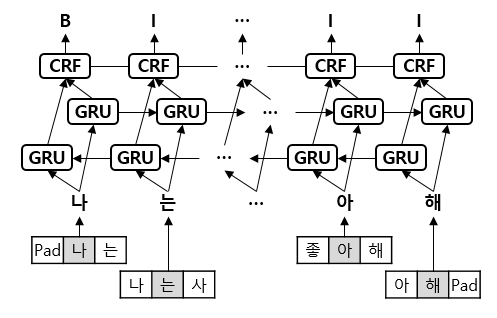

In [ ]:
from IPython.display import Image
Image("/gdrive/My Drive/colab/rnn_crf/bi_gru_crf_with_feature.PNG")